In [1]:
DATA_PATH = './predict.csv'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pickle
import seaborn as sns

In [3]:
data = pd.read_csv(DATA_PATH)
data.head()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,authors_mean_pagerank,authors_mean_productivity,journal_pagerank,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
0,16,1.0,-0.425436,500.0,1.0,1.0,6.0,NaN,NaN,NaN,101.0,66,1653,7,1.0,1.945910
1,8,7.0,-0.571967,134.0,1.0,1.0,6.0,NaN,NaN,NaN,24.0,59,1527,7,32.0,1.945910
2,15,19.0,-0.859644,235.0,1.0,1.0,5.0,NaN,NaN,NaN,49.0,169,1554,6,5.0,1.791759
3,6,4.0,-1.054999,1124.0,1.0,1.0,10.0,NaN,NaN,NaN,185.0,130,2121,11,7.0,2.397895
4,14,2.0,-0.476697,346.0,1.0,1.0,2.0,NaN,NaN,NaN,72.0,100,432,3,7.0,1.098612


***Data processing***

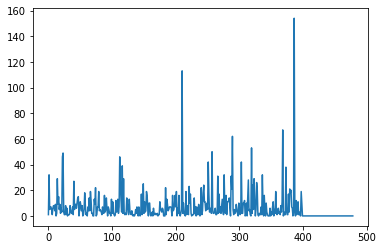

In [4]:
plt.plot(data['c5'])


In [5]:
data.dropna(subset=['c5'], inplace=True)
nan_rate = {f'{column}' : data[column].isna().sum() / len(data[column]) for column in data.columns}
print(nan_rate)
drop_thresholder = 0.3
columns_to_drop = [k for k, v in nan_rate.items() if v > drop_thresholder and k != 'c5']
data.drop(columns_to_drop, axis='columns', inplace=True)

{'recency': 0.0, 'topic_rank': 0.0, 'diversity': 0.0, 'authors_mean_rank': 0.012526096033402923, 'authors_mean_hindex': 0.012526096033402923, 'authors_mean_gindex': 0.012526096033402923, 'authors_mean_sociality': 0.012526096033402923, 'authors_mean_pagerank': 1.0, 'authors_mean_productivity': 1.0, 'journal_pagerank': 1.0, 'journal_rank': 0.081419624217119, 'title_len': 0.0, 'abstract_len': 0.0, 'n_authors': 0.0, 'c5': 0.0, 'log_authors_mean_sociality': 0.012526096033402923}


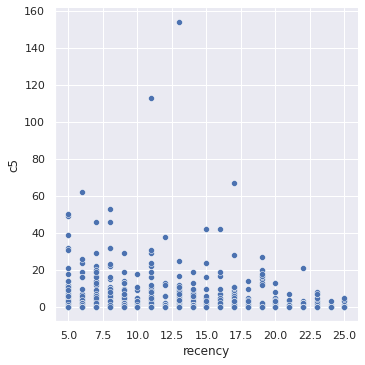

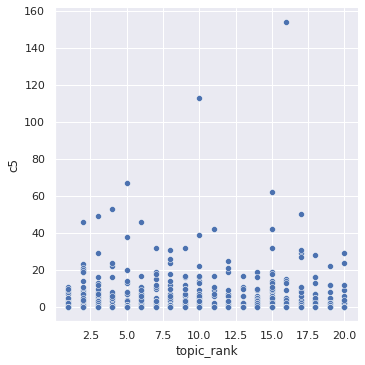

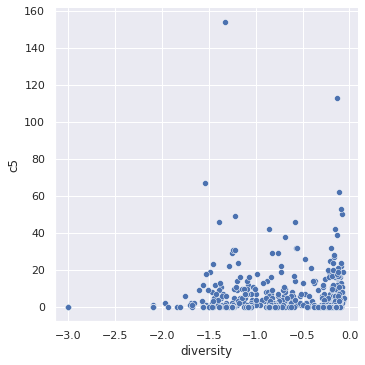

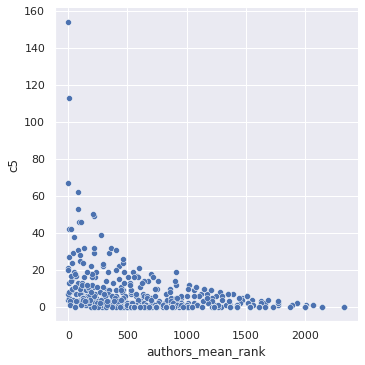

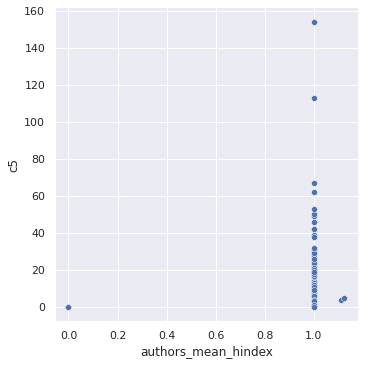

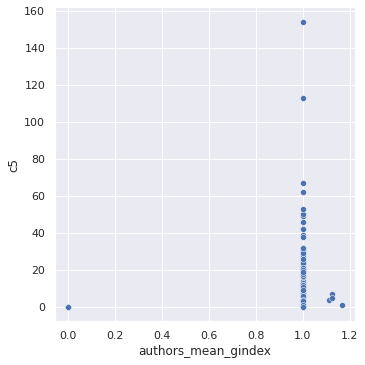

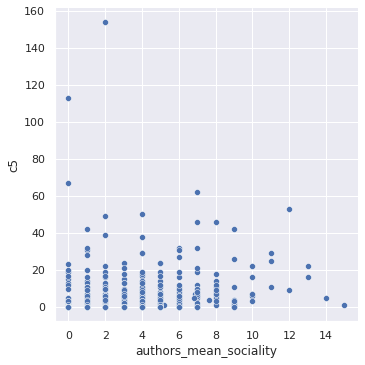

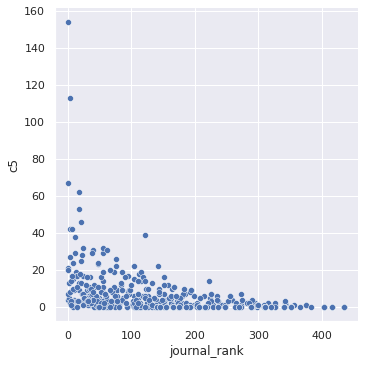

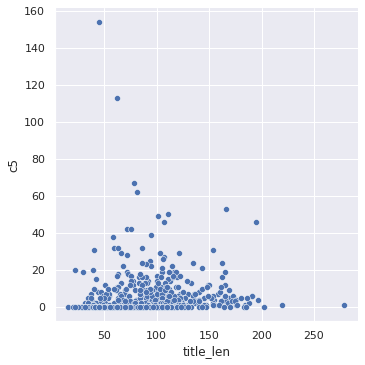

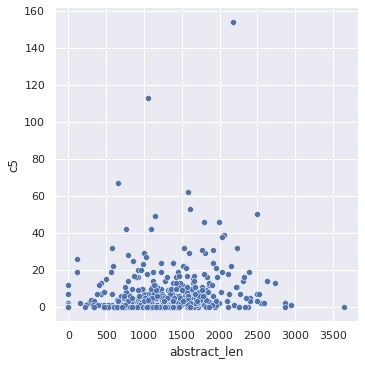

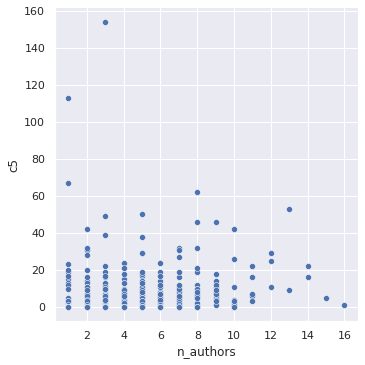

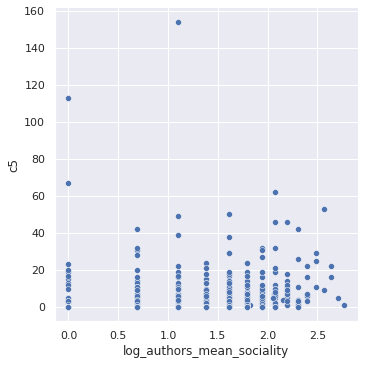

In [6]:
sns.set_theme()
for col in data.columns:
    if col == 'c5':
        continue
    sns.relplot(data=data, x=col, y='c5')


In [7]:
data.corr().style.background_gradient(cmap='coolwarm')

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
recency,1.000000,0.006633,0.134188,-0.605363,-0.053975,-0.056349,-0.207384,-0.501698,-0.098795,-0.184433,-0.211105,-0.205645,-0.196026
topic_rank,0.006633,1.000000,0.007051,0.043518,-0.107014,-0.107936,-0.042892,0.076514,-0.121407,-0.092573,-0.049917,-0.010784,-0.042618
diversity,0.134188,0.007051,1.000000,-0.280521,0.316729,0.316303,0.132571,-0.345223,0.217731,0.451929,0.144574,0.066988,0.178806
authors_mean_rank,-0.605363,0.043518,-0.280521,1.000000,-0.429332,-0.425947,-0.038268,0.935828,-0.011043,-0.171054,-0.038564,-0.353788,-0.049710
authors_mean_hindex,-0.053975,-0.107014,0.316729,-0.429332,1.000000,0.999655,0.217602,-0.532220,0.226990,0.323994,0.217765,0.232115,0.273413
authors_mean_gindex,-0.056349,-0.107936,0.316303,-0.425947,0.999655,1.000000,0.218880,-0.528544,0.227339,0.322870,0.219017,0.231432,0.274711
authors_mean_sociality,-0.207384,-0.042892,0.132571,-0.038268,0.217602,0.218880,1.000000,-0.069038,0.370253,0.314133,0.999969,0.134659,0.928274
journal_rank,-0.501698,0.076514,-0.345223,0.935828,-0.532220,-0.528544,-0.069038,1.000000,-0.091349,-0.288544,-0.084330,-0.361605,-0.094467
title_len,-0.098795,-0.121407,0.217731,-0.011043,0.226990,0.227339,0.370253,-0.091349,1.000000,0.323468,0.378244,0.005062,0.400204
abstract_len,-0.184433,-0.092573,0.451929,-0.171054,0.323994,0.322870,0.314133,-0.288544,0.323468,1.000000,0.330167,0.209358,0.363277


In [8]:
data.drop(['authors_mean_hindex', 'authors_mean_gindex', 'n_authors', 'authors_mean_sociality', 'n_authors', 'journal_rank'], axis='columns', inplace=True)

In [9]:
data.corr().style.background_gradient(cmap='coolwarm')

,recency,topic_rank,diversity,authors_mean_rank,title_len,abstract_len,c5,log_authors_mean_sociality
recency,1.000000,0.006633,0.134188,-0.605363,-0.098795,-0.184433,-0.205645,-0.196026
topic_rank,0.006633,1.000000,0.007051,0.043518,-0.121407,-0.092573,-0.010784,-0.042618
diversity,0.134188,0.007051,1.000000,-0.280521,0.217731,0.451929,0.066988,0.178806
authors_mean_rank,-0.605363,0.043518,-0.280521,1.000000,-0.011043,-0.171054,-0.353788,-0.049710
title_len,-0.098795,-0.121407,0.217731,-0.011043,1.000000,0.323468,0.005062,0.400204
abstract_len,-0.184433,-0.092573,0.451929,-0.171054,0.323468,1.000000,0.209358,0.363277
c5,-0.205645,-0.010784,0.066988,-0.353788,0.005062,0.209358,1.000000,0.104946
log_authors_mean_sociality,-0.196026,-0.042618,0.178806,-0.049710,0.400204,0.363277,0.104946,1.000000


In [10]:
target = np.log1p(data['c5'])
data.drop(['c5'], axis='columns', inplace=True)

In [11]:
imputer = IterativeImputer(random_state=42)
cols = data.columns
data = pd.DataFrame(imputer.fit_transform(data), columns=cols)
with open('imputer_dump.pkl', 'wb') as imp_dump:
    pickle.dump(imputer, imp_dump)


**Training**

In [12]:
def get_best_model(model, data, target, model_parameters, scoring='r2', 
                   cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42),
                   verbose=False):
    gscv = GridSearchCV(model, model_parameters, scoring=scoring, n_jobs=-1, 
                       cv=cv, verbose=verbose)
    gscv.fit(data, target)
    return gscv.best_estimator_ , gscv.best_params_

In [13]:
IS_SEARCHING_PARAMS = False
if IS_SEARCHING_PARAMS:
    params_to_find = {
        'learning_rate' : np.arange(0, 0.4, 0.03),
        'max_depth' : np.arange(1, 16, 2),
        'n_estimators' : np.arange(50, 201, 25),
        'objective' : ['reg:squarederror'],
        'min_child_weight': np.arange(0.5, 4.5, 1),
        'subsample': [0.5, 1.],
        'lambda': np.arange(1, 3, 1),
        'alpha': np.arange(1, 3, 1),
        'num_parallel_tree': np.arange(1, 11, 2),
    }
    xgbr, params = get_best_model(XGBRegressor(), 
                                  data, target, params_to_find, verbose=True)
    train_size = 0.8
    X_train, X_test, Y_train, Y_test = train_test_split(data, target, 
                                                        train_size=train_size)
    
    print(f'Score: {xgbr.score(X_test, Y_test)}')
    print(f'Found parameters: {params}')
else:
    model_params = {
        'learning_rate' : 0.06,
        'max_depth' : 3,
        'min_child_weight' : 0.5,
        'n_estimators' : 175, 
        'subsample' : 0.5,
        'alpha' : 1,
        'lambda' : 1,
        'objective' : 'reg:squarederror', 
        'num_parallel_tree' : 9,
    }
    xgbr = XGBRegressor(**model_params)
    num_repeats = 20
    n_splits = 5
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=num_repeats, random_state=42)
    score_sum = 0.
    for train_index, test_index in rkf.split(data):
        X_train = data.iloc[train_index]
        X_test = data.iloc[test_index]
        Y_train = target.iloc[train_index]
        Y_test = target.iloc[test_index]
        xgbr.fit(X_train, Y_train, 
                 eval_set=[(X_test, Y_test)],
                 eval_metric='rmse',
                 verbose=False
                 )
        score_sum += xgbr.score(X_test, Y_test)
    print(f'Mean score: {score_sum / (num_repeats * n_splits)}')

Mean score: 0.8436196045083993


In [14]:
xgbr.get_booster().get_score(importance_type='gain')

{'abstract_len': 1.1219379022203193,
 'authors_mean_rank': 3.6714129445075656,
 'diversity': 0.48444877455407476,
 'log_authors_mean_sociality': 0.7566845551481328,
 'recency': 3.361521932868508,
 'title_len': 0.5137394879572955,
 'topic_rank': 0.470122936687613}